# Report

I tried to find anomaly in the  logs, to see wich logs are quite different than others. Here is the steps I followed:

1.  First I did some visualizatiuon of data. This step was necessary for me in order to know what kind of data I am dealing with, what are the values in each features, how is the dsitribution of data,.....
2. Next I did feature engineering by mapping or extracing useful piece of data from each field. This includes for example extraing hour,minute, dat from data time, extracing REST operation from REST urls.
3. Next I mapped the categorical features into dummy binary variables.
4. Then I applied K-Means clustering algorithm, I initially started with 10 centroilds, plotted the scores of each round of clutsering and I found out based on elbow heuristics that 4 is the best cluster size.
5. Finally, I measured distance of each row of the log against those centroids and marked those falling far  distance from cluster as "anomalies". They are marked by "1" in "anomaly" column in log data.


There are two notbeook fiels attahced. They both share some similar piece of code:

* The Analysis : includes some visualization of data shows hoo I enbded up with feature engineering, clustering number, etc.

* The Final Model, which only includes the required piece of code for clustering. You just need to run this if you just want the final result (kept in 'anomaly' column)

In [112]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew
from subprocess import check_output


In [113]:
colNames = ['ip','dp1','dp2','date','time','numeric1','rest','rc','numeric2','dp3','client','in','out','us']
# Load data.
train = pd.read_csv('access_logs_201612.txt', delim_whitespace=True, header=None, names=colNames, parse_dates=[3,4])

print(train.shape)

(2529245, 14)


In [114]:
train.head(4)

,ip,dp1,dp2,date,time,numeric1,rest,rc,numeric2,dp3,client,in,out,us
0,147.214.18.128,-,-,2016-11-27,2018-03-18 03:16:03,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,22,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:223,us:2545
1,147.214.18.128,-,-,2016-11-27,2018-03-18 03:16:05,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,21,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:222,us:2187
2,localhost,-,-,2016-11-27,2018-03-18 03:16:07,100,GET /server-status?auto HTTP/1.1,rc:200,387,-,collectd/5.5.1,in:94,out:585,us:475
3,147.214.18.128,-,-,2016-11-27,2018-03-18 03:16:08,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,22,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:223,us:1835


In [3]:
train = train.drop(['dp1','dp2','dp3'], axis =1)

## Exploratory Data Analysis

The first thing that is usually doen are as fillows:
1. Explore distrubution of Target Varibale
2. Explore correlation between Target variable and other features
3. Look at missing and outliers
    3.1 Explore the missing values
    3.2 Explore outliers
    3.3 Impute missing values or drop columns with lot of missing data 
        3.3.1 For numerical datasets, impute missing values with median
        3.3.2 For categorical dataset impute missing values with the most frequent values
    3.4 Remove outliers
4. If necessary transform features with skewed distributions into respective log format
5. Normalize all columns into standard Z distribution (mean=0, sd=[-1,1])

In [6]:
train.describe(include=[np.object])

,ip,rest,rc,client,in,out,us
count,2529245,2529245,2529245,2529245,2529245,2529245,2529245
unique,42,34185,11,30,745036,12741,274309
top,147.214.18.128,POST /rawdata-dispatcher/data/create/payload H...,rc:200,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:162,us:256
freq,2093165,1543662,2457123,2076762,496310,1557946,1855


Some insights:
1. There are only 42 unique IP addresses, 
2. The number of unique REST oeprations is 34185 , which accounts for only 1% of data
3. Only 11 unique RCs
4. The number of unique clients is 30
5. Columns in,out and us can be converted into numeric one by dropping the predix

In [8]:
train[['date','time']].describe()

,date,time
count,2529245,2529245
unique,17,86400
top,2016-12-09 00:00:00,2018-03-17 09:12:02
freq,298444,197
first,2016-11-27 00:00:00,2018-03-17 00:00:00
last,2016-12-13 00:00:00,2018-03-17 23:59:59


In [4]:
train['in']= train['in'].apply(lambda x : int(x.split(":")[1]))
train['out']= train['out'].apply(lambda x : int(x.split(":")[1]))
train['us']= train['us'].apply(lambda x : int(x.split(":")[1]))

In [7]:
train.describe()

,numeric1,numeric2,in,out,us
count,2529245.0,2.529245e+06,2.529245e+06,2.529245e+06,2.529245e+06
mean,100.0,3.222325e+04,6.151072e+05,3.242875e+04,7.254695e+04
std,0.0,4.457347e+05,2.157920e+06,4.457416e+05,8.487997e+05
min,100.0,0.000000e+00,8.200000e+01,1.370000e+02,6.800000e+01
25%,100.0,0.000000e+00,2.440000e+02,1.620000e+02,1.694000e+03
50%,100.0,0.000000e+00,9.866900e+04,1.620000e+02,2.123300e+04
75%,100.0,2.100000e+01,4.784780e+05,2.220000e+02,6.224800e+04
max,100.0,6.529616e+06,6.106426e+07,6.529896e+06,9.271657e+08


### Visualization

#### Single Feature visualization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b1ea86978>], dtype=object)

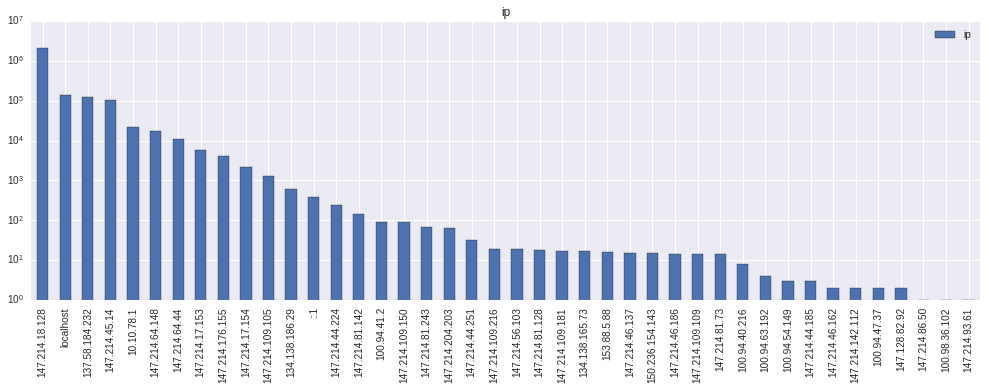

In [22]:
train[['ip']].apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(17,5), logy=True)

* We have (-1) as IP address which is probably noise

We can see Four groups of IP addresses
* IPs starting with 147.214
* IP starting 137.58, 134.138
* Local ip adrresses: localhost and 10.10
* Carried dedictaed IPs: 100.X

If we map these IP addresses to these four groups, then we can see distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b1e44a978>], dtype=object)

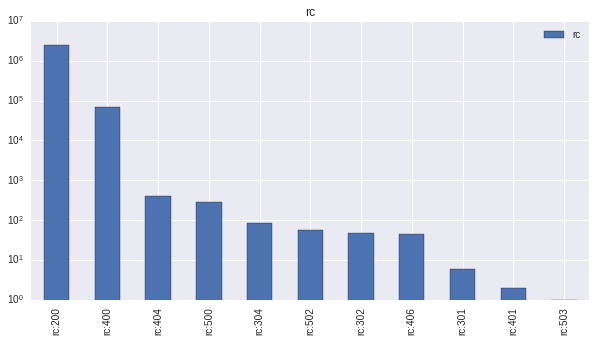

In [24]:
train[['rc']].apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(10,5), logy=True)

* RC seems to be HTTP response code, 200:OK, 404: not found,...etc. This feature should be treated as categorical

However, if me measure the number of requests per IP adress, per time unit then we might find some anomalies



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f745765a4a8>], dtype=object)

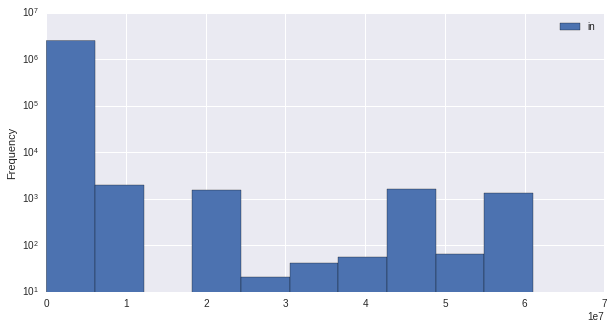

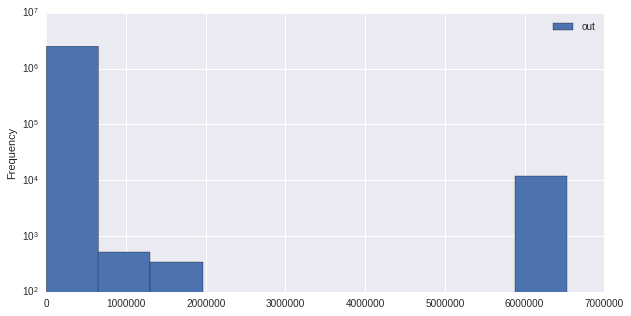

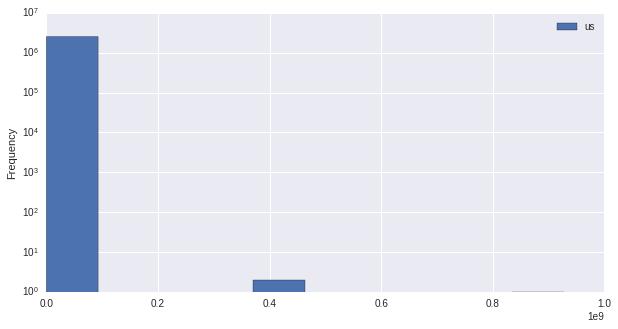

In [10]:
train[['in']].plot(kind='hist', subplots=True, figsize=(6,3), logy=True)
train[['out']].plot(kind='hist', subplots=True, figsize=(6,3), logy=True)
train[['us']].plot(kind='hist', subplots=True, figsize=(6,3), logy=True)

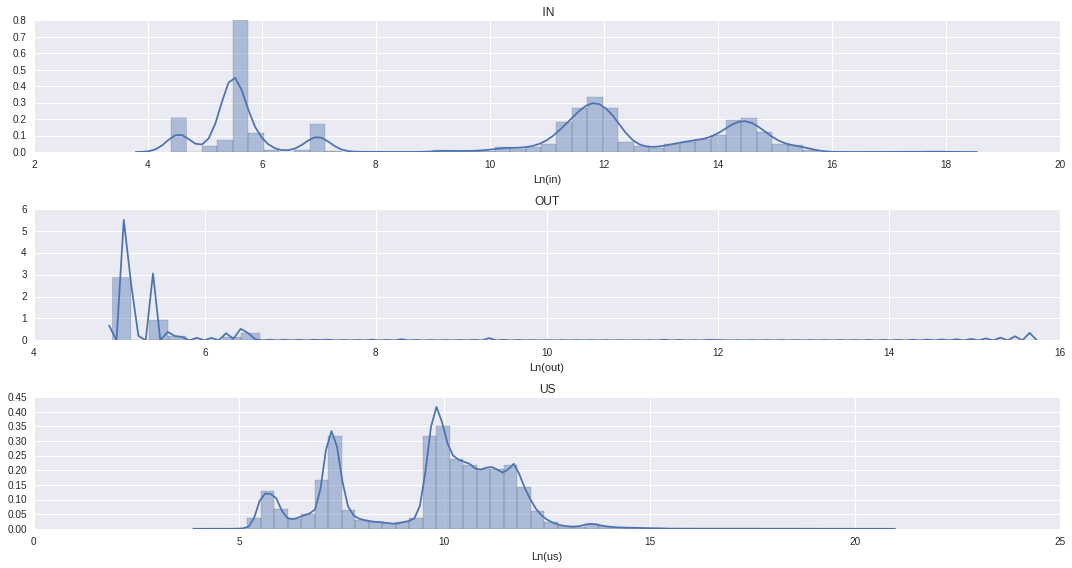

In [58]:
target = train['in'] 
target_log = np.log(target)
target_log = target_log.apply (lambda x : 0 if x == - np.inf else x)
plt.subplots(figsize=(15, 8))
plt.subplot(3,1,1)
sns.distplot(target_log, bins=50)
plt.title(' IN')
plt.xlabel('Ln(in)')

target = train['out'] 
target_log = np.log(target)
target_log = target_log.apply (lambda x : 0 if x == - np.inf else x)
plt.subplot(3,1,2)
sns.distplot(target_log, bins=50)
plt.title('OUT')
plt.xlabel('Ln(out)')

target = train['us'] 
target_log = np.log(target)
target_log = target_log.apply (lambda x : 0 if x == - np.inf else x)
plt.subplot(3,1,3)
sns.distplot(target_log, bins=50)
plt.title('US')
plt.xlabel( 'Ln(us)')
plt.tight_layout()

* It seems that in,out and us features quited clustered around certian distributions, wich could show some hints for anomaly detection


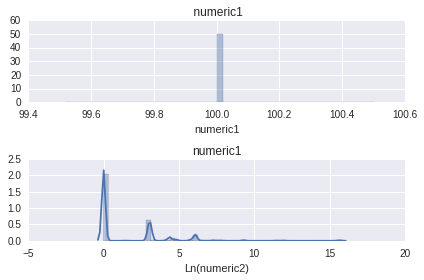

In [62]:
#plt.subplots(figsize=(15, 8))
plt.subplot(2,1,1)
sns.distplot(train['numeric1'] , bins=50)
plt.title(' numeric1')
plt.xlabel('numeric1')

target = train['numeric2'] 
target_log = np.log(target)
target_log = target_log.apply (lambda x : 0 if x == - np.inf else x)
plt.subplot(2,1,2)
sns.distplot(target_log, bins=50)
plt.title('numeric1')
plt.xlabel('Ln(numeric2)')

plt.tight_layout()

Apparently there are some outliers in the dataset, which can be seen in the followings as well:

In [37]:
train[['numeric1','numeric2']].describe()

,numeric1,numeric2
count,2529245.0,2.529245e+06
mean,100.0,3.222325e+04
std,0.0,4.457347e+05
min,100.0,0.000000e+00
25%,100.0,0.000000e+00
50%,100.0,0.000000e+00
75%,100.0,2.100000e+01
max,100.0,6.529616e+06


In [115]:
def extractResourceOp(restserv):
    arr = restserv.split(" ")
    op = arr[0]
    url = arr[1]
    protocol=arr[2]
    resource=url.split("?")[0]
    return [op, resource,protocol]


def extractOp(restserv):
    arr = restserv.split(" ")
    op = arr[0]
    return [op]

train[['operation','resource','protocol']] = train.apply(lambda row:pd.Series(extractResourceOp(row['rest'])),
                                                           axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8839c664a8>], dtype=object)

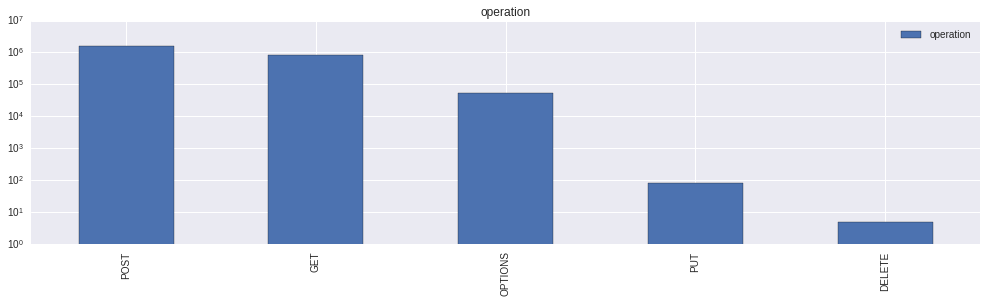

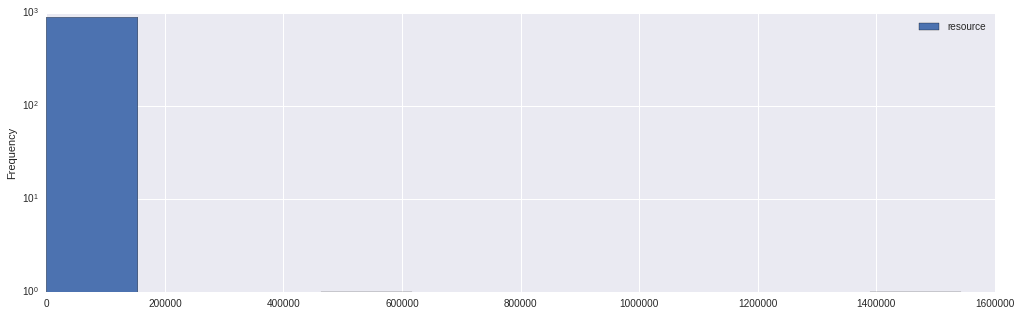

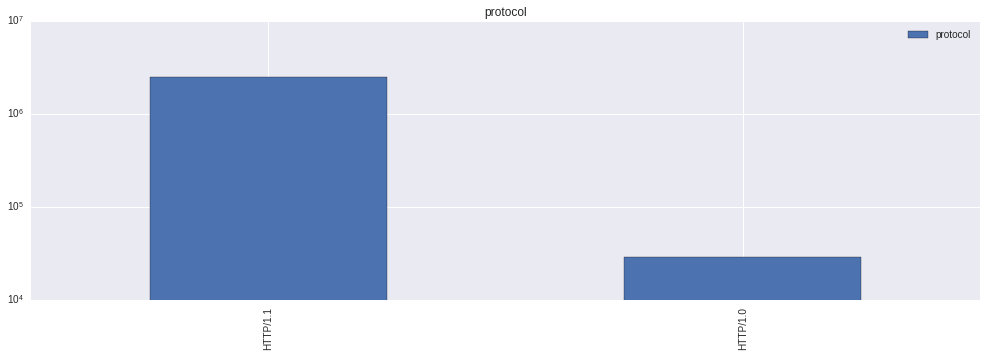

In [116]:
train[['operation']].apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(17,4), logy=True)
train[['resource']].apply(pd.value_counts).plot(kind='hist', subplots=True, figsize=(17,5), logy=True)
train[['protocol']].apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(17,5), logy=True)

## Feature Engineering

#### 1- Extracing  year,month,day hour, minutes features

In [8]:
def extractTimeFeatures(row):
    hour = row.hour
    minute = row.minute
    return [hour,minute]
train[['hour', 'minute']] = train.apply(lambda row:pd.Series(extractTimeFeatures(row['time'])),axis=1)

In [9]:
def extractDateFeatures(row):   
    day = row.dayofweek
    return day
train['day'] = train['date'].apply(lambda x : extractDateFeatures(x))

#### 2- Categorizing IP address

In [10]:
def extracFirstIpPart(x):
    return x.split(".")[0]
train['first_ip_part'] = train['ip'].apply (lambda x : extracFirstIpPart(x))

In [12]:
train.groupby(['first_ip_part'])['ip'].count()

first_ip_part
10             22435
100              109
134              630
137           124254
147          2239689
150               15
153               16
::1              396
localhost     141701
Name: ip, dtype: int64

Lets map the above ip segments into dummay variables

In [13]:
def mapIpToColumn(part):   
    if (part.startswith("10")):
        return [0, 0, 0]
    if (part.startswith("100")):
        return [0, 0, 1]
    if (part.startswith("134")):
        return [0, 1, 0]    
    if (part.startswith("137")):
        return [0, 1,  1]
    if (part.startswith("147")):
        return [1 ,0, 0]
    if (part.startswith("150") | part.startswith("153")):
        return [1, 0, 1]
    if (part.startswith("localhost") ):
        return [1, 1, 0]
    return [1,1,1] 
    

In [14]:
train[['ip_3', 'ip_2', 'ip_1']] = train.apply(lambda row:pd.Series(mapIpToColumn(row['first_ip_part'])),
                                                           axis=1)

#### 3-Operarion

In [16]:
train.groupby(['operation'])['operation'].count()

operation
DELETE           5
GET         826154
OPTIONS      52743
POST       1650262
PUT             81
Name: operation, dtype: int64

In [17]:
def mapOperationToColumn(part):   
    if (part.startswith("DELETE")):
        return [0, 0, 0]
    if (part.startswith("GET")):
        return [0, 0, 1]
    if (part.startswith("OPTIONS")):
        return [0, 1, 0]    
    if (part.startswith("POST")):
        return [0, 1,  1]
    if (part.startswith("PUT")):
        return [1 ,0, 0]   
    return [1, 0, 1]   


In [18]:
train[['op_3', 'op_2', 'op_1']] = train.apply(lambda row:pd.Series(mapOperationToColumn(row['operation'])),
                                                           axis=1)

## K-Means Clustering

In [98]:
#Euclidean distance
def measureDistance(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]        
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [97]:
#import gc
#gc.collect()

5963

In [25]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# We take only numeric feature and standardize them
data = train.select_dtypes(include=[np.int64, np.float64])
data = data.drop (["numeric1"], axis=1)

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# we reduce to 2 importants features (for the sake of visualization)
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# And standardizing these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

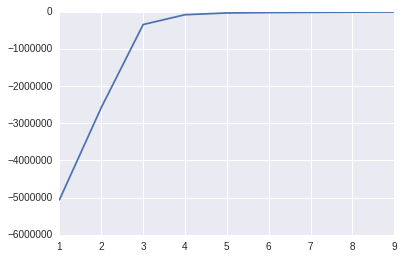

In [26]:
# Lets start with 20 centroids to see the loss plot (elbow method)
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

plt.show()

#### OK, it seems that we endup with 4 clusters

In [28]:
train['cluster'] = kmeans[3].predict(data)
train['principal_feature1'] = data[0]
train['principal_feature2'] = data[1]
train['cluster'].value_counts()

0    2227885
3     164909
2     124647
1      11804
Name: cluster, dtype: int64

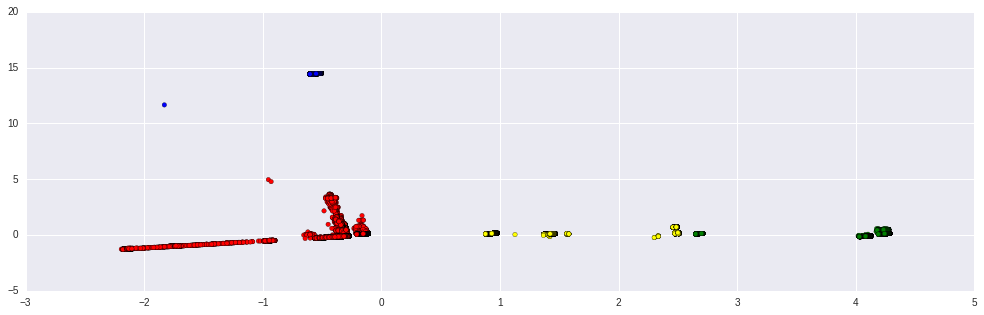

In [29]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(17,5))
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
ax.scatter(train['principal_feature1'], train['principal_feature2'], c=train["cluster"].apply(lambda x: colors[x]))

plt.show()